# House pricing on the basis of square footage and realtor assesment

## Introduction

Authors:
 - Nicolas Duc
 - Piotr Kula

#### Goal of this project 
The goal of this project is analysis of the market prices of houses on the basis of the square footage and the realtor's assesment.

The proposed model can be then used to asses if the given price is a good deal and to check whether the house price is comparable to the market standard.

## Data

The data was obtained from kaggle.com.

Dataset contains different types of data such as numner of bedrooms, zipcode, year it was built, we only use the square footage of the living space and the grade that the realtor has given to the house.

The dataset itself contains over 21000 records, however for the purpose of the project we sample 100 records that will later be used.

In [90]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd
# print(len(pd.read_csv('kc_house_data.csv')))
df = (pd.read_csv("house_data_sampled.csv").sample(100)).reset_index()
# print(df.head())
# df.columns
df['price'].mean()

541517.08

In [91]:

mean_sqft_living = (df['sqft_living']).mean()
mean_grade = (df['grade']).mean()
sd_sqft_living = (df['sqft_living']).std()
print(sd_sqft_living)
print(mean_sqft_living)
sd_grade = (df['grade']).std()
sqft_living_standardized = ((df['sqft_living']).copy())
price_standardized = ((df['price']).copy())
sqft_living_centered = ((df['sqft_living']).copy())

grade_standardized = (df['grade']).copy()
print(sqft_living_standardized)
for i in range(len(df['sqft_living'])):
    sqft_living_centered[i] = ((df['sqft_living'])[i]-mean_sqft_living)
    sqft_living_standardized[i] = ((df['sqft_living'])[i]-mean_sqft_living)/sd_sqft_living
    grade_standardized[i] = (df['grade'][i]-mean_grade)/sd_grade
    price_standardized[i] = (df['price'][i]-(df['price']).mean())/(df['price']).std()
print(sqft_living_standardized.head())
print(sqft_living_standardized[0])
# print(grade_standardized)

864.2521496541492
2153.86
0     3520
1     2630
2     1370
3     2330
4     1330
      ... 
95    1500
96    2790
97    1250
98    2460
99    2750
Name: sqft_living, Length: 100, dtype: int64
0    1.580719
1    0.550927
2   -0.906981
3    0.203806
4   -0.953263
Name: sqft_living, dtype: float64
1.5807192386466067


In [92]:
grade_moved = ((df['grade']).copy())
for i in range(len(grade_moved)):
    grade_moved[i] = int(grade_moved[i]-6)
print(f"MIN: {grade_moved.min()} MAX: {grade_moved.max()}")

MIN: 0 MAX: 5


In [93]:
mean_price = (df['price']).mean()
print(mean_price)

541517.08


## Model 1 - one parameter

### Prior

The parameters for the prior have been selected on the basis of a 

In [94]:
sqft_linspace = np.linspace(sqft_living_centered.min(),sqft_living_centered.max())
data = {'N': len(sqft_linspace),
        'sqft': sqft_linspace}

In [95]:
one_param_ppc_a = CmdStanModel(stan_file='CommandFiles/one_param_ppc.stan')
one_param_ppc_a_simulated = one_param_ppc_a.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


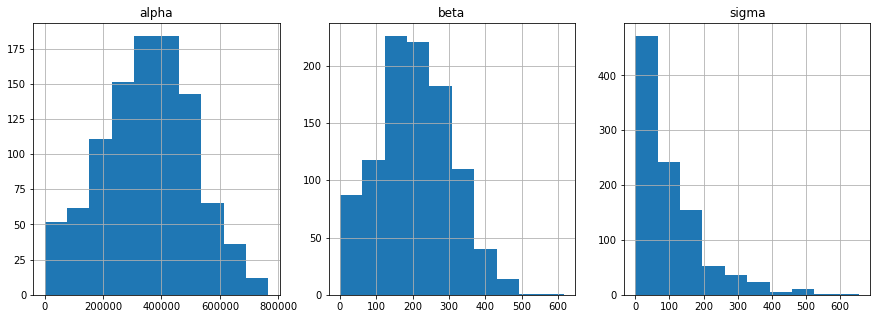

,mean,sd,hdi_3%,hdi_97%
alpha,352321.48,158063.89,0.0,592987.00
beta,206.29,101.33,0.0,364.79
sigma,100.88,99.54,0.0,295.96


In [96]:
alpha_sim = one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim = one_param_ppc_a_simulated.stan_variable('beta')
sigma_sim = one_param_ppc_a_simulated.stan_variable('sigma')
price_sim = one_param_ppc_a_simulated.stan_variable('price')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim);
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim);
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim);
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_ppc_a_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

Text(0, 0.5, 'Price [USD]')

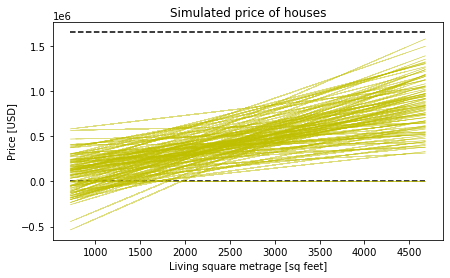

In [97]:
alpha_sim=one_param_ppc_a_simulated.stan_variable('alpha')
beta_sim=one_param_ppc_a_simulated.stan_variable('beta')

# plt.plot(beta_sim)
# plt.title("grade")
# plt.show()
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [0,(df['price']).max()],
    xmin=df['sqft_living'].min(),
    xmax=df['sqft_living'].max(),
    linestyle='--',color='black'
    )
for i in range(100):
    axes.plot(
        df['sqft_living'],
        alpha_sim[i]+beta_sim[i]*sqft_living_centered,
        color = 'y',alpha=0.5,linewidth=0.5
        )
plt.title("Simulated price of houses");
plt.xlabel("Living square metrage [sq feet]")
plt.ylabel("Price [USD]")

### Posterior

In [98]:
data = {'N': len(sqft_living_centered),
        'sqft': sqft_living_centered,
        'price': df['price']}
one_param = CmdStanModel(stan_file='CommandFiles/one_param.stan')
one_param_simulated = one_param.sample(data=data, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


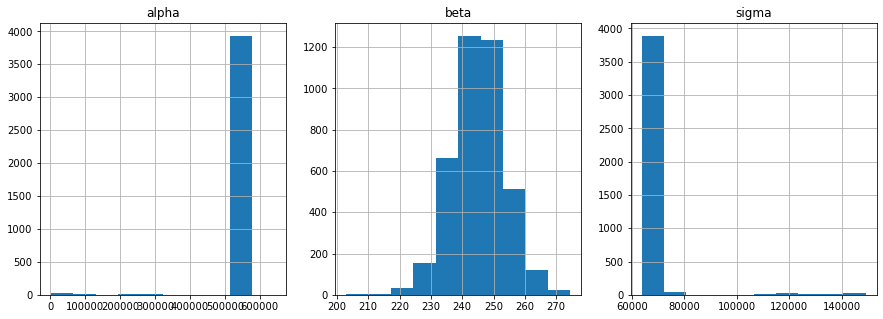

,mean,sd,hdi_3%,hdi_97%
alpha,534431.12,54446.48,527117.00,554699.00
beta,245.20,8.38,228.74,260.35
sigma,69821.83,8253.26,65865.10,71834.70


In [99]:
alpha_sim = one_param_simulated.stan_variable('alpha')
beta_sim = one_param_simulated.stan_variable('beta')
sigma_sim = one_param_simulated.stan_variable('sigma')
price_sim = one_param_simulated.stan_variable('price_sim')

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sim)
axs[1].grid()
axs[1].set_title('beta')
axs[2].hist(sigma_sim)
axs[2].grid()
axs[2].set_title('sigma')
plt.show()

az.summary(one_param_simulated,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

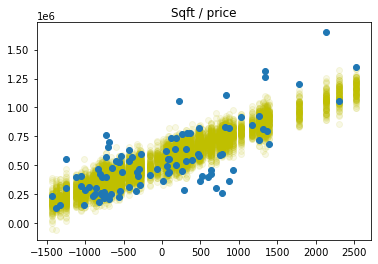

In [100]:
prices_sim=one_param_simulated.stan_variable('price_sim')

# for i in range(0,len(df['sqft_living'])):
for i in range(100):
    plt.scatter(sqft_living_centered, prices_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_centered, df["price"])

plt.title("Sqft / price")
plt.show()

## Model 2 - discrete grade

### Prior

In [144]:
sqft_linspace = np.linspace(sqft_living_standardized.min(),sqft_living_standardized.max(),100)
grade_in = grade_moved.sample(100).sort_values()

data = {'N': len(sqft_linspace),
        'sqft': sqft_living_centered,
        'grade': grade_in}
two_params_discrete_ppc = CmdStanModel(stan_file='CommandFiles/two_param_discrete_ppc.stan')
two_params_discrete_ppc_simulated = two_params_discrete_ppc.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


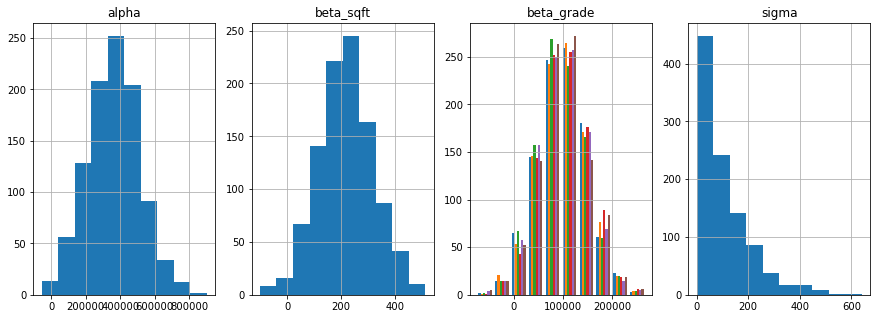

,mean,sd,hdi_3%,hdi_97%
alpha,-0.03,0.48,-0.92,1.34
beta_sqft,0.20,0.47,0.00,1.20
beta_grade,0.19,0.44,0.00,1.19
sigma,23.35,64.51,0.00,128.99


In [108]:
alpha_sim = two_params_discrete_ppc_simulated.stan_variable('alpha')
beta_grade_sim = two_params_discrete_ppc_simulated.stan_variable('beta_grade')
beta_sqft_sim = two_params_discrete_ppc_simulated.stan_variable('beta_sqft')
sigma_sim = two_params_discrete_ppc_simulated.stan_variable('sigma')
price_sim = two_params_discrete_ppc_simulated.stan_variable('price')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_ppc_simulated,var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

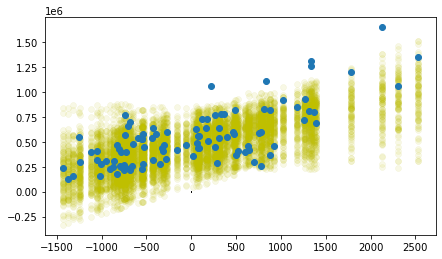

In [168]:
price_sim = two_params_discrete_ppc_simulated.stan_variable('price')


fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [price_standardized.min(),price_standardized.max()],
    xmin=sqft_living_standardized.min(),
    xmax=sqft_living_standardized.max(),
    linestyle='--', color='black'
    )
for i in range(100):
    plt.scatter(
        sqft_living_centered,
        price_sim[i],
        color = 'y', alpha=0.1, linewidth=0.5
        )

plt.scatter(sqft_living_centered, df['price'])

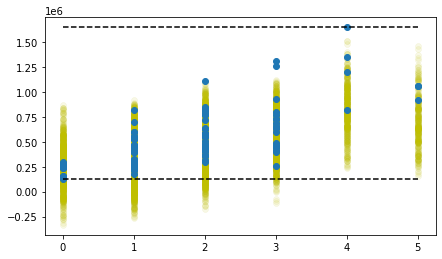

In [169]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines(
    [df['price'].min(),df['price'].max()],
    xmin=grade_moved.min(),
    xmax=grade_moved.max(),
    linestyle='--', color='black'
    )
for i in range(100):
    plt.scatter(
        grade_moved,
        price_sim[i],
        color = 'y', alpha=0.1, linewidth=0.5
        )

plt.scatter(grade_moved, df['price'])

### Posterior

In [145]:
data = {'N': len(sqft_living_standardized),
        'sqft': sqft_living_standardized,
        'grade': grade_moved,
        'price': df['price']}
two_params_discrete = CmdStanModel(stan_file='CommandFiles/two_param_discrete.stan')
two_params_simulated_discrete = two_params_discrete.sample(data=data, seed=21370204)

INFO:cmdstanpy:compiling stan file /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete.stan to exe file /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete
INFO:cmdstanpy:compiled model executable: /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete.hpp /home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete.stan
Warning in '/home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/nicolas/Projects/DA_project/CommandFiles/two_param_discrete.stan', line 33, column 3: Declaration
    of arrays by placing brackets after a v


INFO:cmdstanpy:CmdStan done processing.


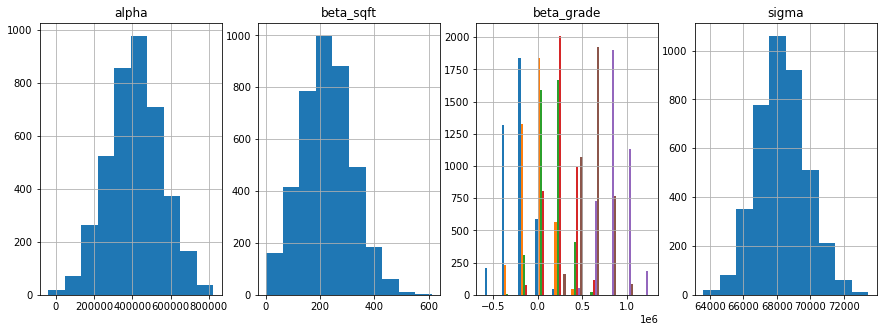

,mean,sd,hdi_3%,hdi_97%
alpha,-0.03,0.48,-0.92,1.34
beta_sqft,0.20,0.47,0.00,1.20
beta_grade,0.19,0.44,0.00,1.19
sigma,23.35,64.51,0.00,128.99


In [147]:
alpha_sim = two_params_simulated_discrete.stan_variable('alpha')
beta_grade_sim = two_params_simulated_discrete.stan_variable('beta_grade')
beta_sqft_sim = two_params_simulated_discrete.stan_variable('beta_sqft')
sigma_sim = two_params_simulated_discrete.stan_variable('sigma')
price_sim = two_params_simulated_discrete.stan_variable('prices')

fig, axs = plt.subplots(1,4)
fig.set_size_inches(15, 5)
axs[0].hist(alpha_sim)
axs[0].grid()
axs[0].set_title('alpha')
axs[1].hist(beta_sqft_sim)
axs[1].grid()
axs[1].set_title('beta_sqft')
axs[2].hist(beta_grade_sim)
axs[2].grid()
axs[2].set_title('beta_grade')
axs[3].hist(sigma_sim)
axs[3].grid()
axs[3].set_title('sigma')
plt.show()

az.summary(two_params_ppc_simulated,var_names=['alpha','beta_sqft', 'beta_grade','sigma'],round_to=2,kind='stats')

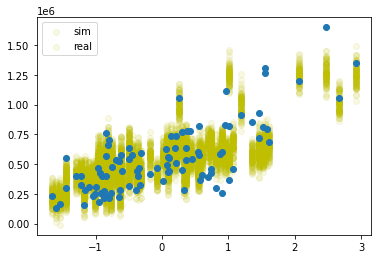

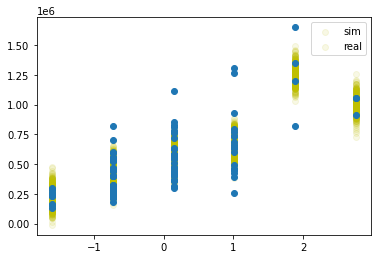

In [170]:
price_sim = two_params_simulated_discrete.stan_variable('prices')


for i in range(100):
    plt.scatter(sqft_living_standardized, price_sim[i], color="y", alpha=0.1)

plt.scatter(sqft_living_standardized,df['price'])
plt.legend(["sim", "real"])
plt.show()

for i in range(100):
    plt.scatter(grade_standardized, price_sim[i], color="y", alpha=0.1)
plt.scatter(grade_standardized,df['price'])
plt.legend(["sim", "real"])

## Comparison of models

In [164]:
idata1 = az.from_cmdstanpy(posterior = one_param_simulated, log_likelihood = "log_lik");
idata2 = az.from_cmdstanpy(posterior=two_params_simulated_discrete, log_likelihood="log_lik") ;
compare_dict = {"one_param_model": idata1, "two_param_discrete": idata2};

out_loo = az.compare(compare_dict, ic = "loo");
out_waic = az.compare(compare_dict, ic = "waic"); # loo stands for leave one out cross validation

/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/nicolas/anaconda3/envs/cmdstan/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differ

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
two_param_discrete,0,-1631.947676,62.732548,0.000000,0.716036,81.149061,0.000000,True,log
one_param_model,1,-1718.807229,209.811366,86.859553,0.283964,63.807907,70.001551,True,log


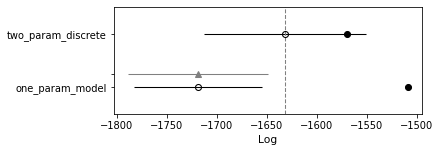

In [165]:
az.plot_compare(out_loo)
out_loo

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
one_param_model,0,-1605.204270,96.208406,0.000000,0.405631,54.037407,0.000000,True,log
two_param_discrete,1,-1629.822965,60.607838,24.618695,0.594369,80.641035,65.600771,True,log


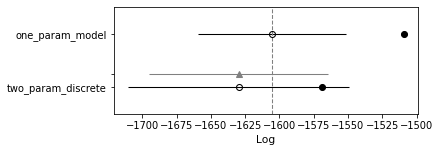

In [166]:
az.plot_compare(out_waic)
out_waic


1. The warnings are most likey caused by the outliers in the data: https://discourse.mc-stan.org/t/number-of-points-with-pareto-k-0-7-increases-when-a-subset-of-the-data-set-is-used/91081.